In [ ]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import scipy.stats as st
import seaborn as sns

# Getting the Data

In [2]:
# Codes for each Data Frame

diabetes_csv = "Data/National_Data.csv"
diabetes_df = pd.read_csv(diabetes_csv)
diabetes_df

,yearid,fipscode,raceid,ageid,genderid,educationid,indicatorid,miscid,datasourceid,estimateid,SuppressID,datasetid,GeoLevel,Estimate,SeEstimate,LowerLimit,UpperLimit
0,1980,-1,0,5,0,0,1,0,30,61,0,40,National,1,0.1,0.9,1.2
1,1980,-1,0,5,0,0,1,0,30,101,0,40,National,915,76,764,1065
2,1980,-1,0,6,0,0,1,0,3,61,0,3,National,5.4,0.3,4.8,6
3,1980,-1,0,6,0,0,1,0,3,101,0,3,National,2337,143,2054,2621
4,1980,-1,0,6,0,0,1,0,30,61,0,40,National,5.4,0.3,4.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29097,2017,-1,1,100,0,0,2,0,3,72,0,31,National,6.1,0.5,5.2,7.1
29098,2017,-1,2,99,0,0,2,0,3,72,0,31,National,8.7,1.2,6.6,11.5
29099,2017,-1,2,100,0,0,2,0,3,72,0,31,National,9.2,1.3,7,12.1
29100,2017,-1,7,99,0,0,2,0,3,72,0,31,National,9.7,1.6,7,13.4


In [3]:
# Education ID Value Counts

diabetes_df["educationid"].value_counts()

0    26000
3     1034
2     1034
1     1034
Name: educationid, dtype: int64

In [8]:
# Level 0 Education All

diabetes_df[diabetes_df["educationid"] == 0]

,yearid,fipscode,raceid,ageid,genderid,educationid,indicatorid,miscid,datasourceid,estimateid,SuppressID,datasetid,GeoLevel,Estimate,SeEstimate,LowerLimit,UpperLimit
0,1980,-1,0,5,0,0,1,0,30,61,0,40,National,1,0.1,0.9,1.2
1,1980,-1,0,5,0,0,1,0,30,101,0,40,National,915,76,764,1065
2,1980,-1,0,6,0,0,1,0,3,61,0,3,National,5.4,0.3,4.8,6
3,1980,-1,0,6,0,0,1,0,3,101,0,3,National,2337,143,2054,2621
4,1980,-1,0,6,0,0,1,0,30,61,0,40,National,5.4,0.3,4.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29097,2017,-1,1,100,0,0,2,0,3,72,0,31,National,6.1,0.5,5.2,7.1
29098,2017,-1,2,99,0,0,2,0,3,72,0,31,National,8.7,1.2,6.6,11.5
29099,2017,-1,2,100,0,0,2,0,3,72,0,31,National,9.2,1.3,7,12.1
29100,2017,-1,7,99,0,0,2,0,3,72,0,31,National,9.7,1.6,7,13.4


In [6]:
# Level 1 Education < Highschool

diabetes_df[diabetes_df["educationid"] == 1]

,yearid,fipscode,raceid,ageid,genderid,educationid,indicatorid,miscid,datasourceid,estimateid,SuppressID,datasetid,GeoLevel,Estimate,SeEstimate,LowerLimit,UpperLimit
20,1980,-1,0,99,0,1,1,0,30,61,0,40,National,6.4,0.3,5.8,7
21,1980,-1,0,99,0,1,1,0,30,101,0,40,National,2918,177,2569,3267
36,1980,-1,0,100,0,1,1,0,30,61,0,40,National,5,0.2,4.5,5.5
87,1981,-1,0,99,0,1,1,0,30,61,0,40,National,6.4,0.3,5.8,7.1
88,1981,-1,0,99,0,1,1,0,30,101,0,40,National,2943,174,2601,3285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29047,2015,-1,0,100,0,1,2,0,3,72,0,31,National,11,1,9.1,13.3
29063,2016,-1,0,99,0,1,2,0,3,72,0,31,National,11.9,1.4,9.5,14.8
29069,2016,-1,0,100,0,1,2,0,3,72,0,31,National,11.5,1.3,9.1,14.4
29085,2017,-1,0,99,0,1,2,0,3,72,0,31,National,12.5,1.9,9.4,16.8


In [7]:
diabetes_df[diabetes_df["educationid"] == 0].count()

yearid          26000
fipscode        26000
raceid          26000
ageid           26000
genderid        26000
educationid     26000
indicatorid     26000
miscid          26000
datasourceid    26000
estimateid      26000
SuppressID      26000
datasetid       26000
GeoLevel        26000
Estimate        26000
SeEstimate      26000
LowerLimit      26000
UpperLimit      26000
dtype: int64

In [9]:
# Level 2 Education Highschool

diabetes_df[diabetes_df["educationid"] == 2]

,yearid,fipscode,raceid,ageid,genderid,educationid,indicatorid,miscid,datasourceid,estimateid,SuppressID,datasetid,GeoLevel,Estimate,SeEstimate,LowerLimit,UpperLimit
22,1980,-1,0,99,0,2,1,0,30,61,0,40,National,2.5,0.2,2.2,2.8
23,1980,-1,0,99,0,2,1,0,30,101,0,40,National,1462,116,1234,1691
37,1980,-1,0,100,0,2,1,0,30,61,0,40,National,2.9,0.2,2.5,3.3
89,1981,-1,0,99,0,2,1,0,30,61,0,40,National,2.6,0.2,2.3,3
90,1981,-1,0,99,0,2,1,0,30,101,0,40,National,1609,121,1370,1849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29048,2015,-1,0,100,0,2,2,0,3,72,0,31,National,7.8,0.7,6.5,9.3
29064,2016,-1,0,99,0,2,2,0,3,72,0,31,National,7.2,0.7,5.9,8.8
29070,2016,-1,0,100,0,2,2,0,3,72,0,31,National,6.8,0.7,5.6,8.2
29086,2017,-1,0,99,0,2,2,0,3,72,0,31,National,6.3,0.8,4.9,8


In [10]:
# Level 3 Education > Highschool

diabetes_df[diabetes_df["educationid"] == 3]

,yearid,fipscode,raceid,ageid,genderid,educationid,indicatorid,miscid,datasourceid,estimateid,SuppressID,datasetid,GeoLevel,Estimate,SeEstimate,LowerLimit,UpperLimit
24,1980,-1,0,99,0,3,1,0,30,61,0,40,National,2.1,0.2,1.8,2.5
25,1980,-1,0,99,0,3,1,0,30,101,0,40,National,1033,105,826,1240
38,1980,-1,0,100,0,3,1,0,30,61,0,40,National,2.9,0.3,2.4,3.5
91,1981,-1,0,99,0,3,1,0,30,61,0,40,National,1.7,0.1,1.5,2.1
92,1981,-1,0,99,0,3,1,0,30,101,0,40,National,920,88,747,1092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29049,2015,-1,0,100,0,3,2,0,3,72,0,31,National,5.4,0.3,4.8,6.1
29065,2016,-1,0,99,0,3,2,0,3,72,0,31,National,5.7,0.4,5,6.5
29071,2016,-1,0,100,0,3,2,0,3,72,0,31,National,5.6,0.4,4.9,6.3
29087,2017,-1,0,99,0,3,2,0,3,72,0,31,National,6,0.5,5.1,7.1


In [11]:
# Columns in the Dataframe

diabetes_df.columns

Index(['yearid', 'fipscode', 'raceid', 'ageid', 'genderid', 'educationid',
       'indicatorid', 'miscid', 'datasourceid', 'estimateid', 'SuppressID',
       'datasetid', 'GeoLevel', 'Estimate', 'SeEstimate', 'LowerLimit',
       'UpperLimit'],
      dtype='object')

# Reduce Columns and Add the Column Education

In [12]:
# Reduct column numbers, leave only necessary for this study

diabetes_education_df = diabetes_df.loc[:,["indicatorid","ageid","estimateid",
                                        "datasetid","educationid","yearid","Estimate"]]

In [13]:
diabetes_education_df

,indicatorid,ageid,estimateid,datasetid,educationid,yearid,Estimate
0,1,5,61,40,0,1980,1
1,1,5,101,40,0,1980,915
2,1,6,61,3,0,1980,5.4
3,1,6,101,3,0,1980,2337
4,1,6,61,40,0,1980,5.4
...,...,...,...,...,...,...,...
29097,2,100,72,31,0,2017,6.1
29098,2,99,72,31,0,2017,8.7
29099,2,100,72,31,0,2017,9.2
29100,2,99,72,31,0,2017,9.7


In [14]:
# Education DF. Rename the educationid indicator using cut/bins

# Create bins
bins = [0,1,2,3]

# Create labels
labels = ["< Highschool","Highschool","> Highschool"]

In [15]:
# Slice data and place it into bins
diabetes_education_df["Education"] = pd.cut(diabetes_df["educationid"], bins,
                                           labels=labels)


In [16]:
diabetes_education_df[diabetes_education_df["indicatorid"] == 1]

,indicatorid,ageid,estimateid,datasetid,educationid,yearid,Estimate,Education
0,1,5,61,40,0,1980,1,NaN
1,1,5,101,40,0,1980,915,NaN
2,1,6,61,3,0,1980,5.4,NaN
3,1,6,101,3,0,1980,2337,NaN
4,1,6,61,40,0,1980,5.4,NaN
...,...,...,...,...,...,...,...,...
28261,1,99,61,40,0,2017,10.4,NaN
28262,1,99,101,3,0,2017,4118,NaN
28263,1,99,101,40,0,2017,4087,NaN
28264,1,100,61,3,0,2017,9.3,NaN


# Cleaning the Data

In [17]:
# New Dataframe Cleaned only with education levels

education_clean_df = diabetes_education_df.dropna()

In [18]:
education_clean_df.head()

,indicatorid,ageid,estimateid,datasetid,educationid,yearid,Estimate,Education
20,1,99,61,40,1,1980,6.4,< Highschool
21,1,99,101,40,1,1980,2918,< Highschool
22,1,99,61,40,2,1980,2.5,Highschool
23,1,99,101,40,2,1980,1462,Highschool
24,1,99,61,40,3,1980,2.1,> Highschool


# Number in 1000s (estimateid = 101)

In [19]:
education_clean_df

,indicatorid,ageid,estimateid,datasetid,educationid,yearid,Estimate,Education
20,1,99,61,40,1,1980,6.4,< Highschool
21,1,99,101,40,1,1980,2918,< Highschool
22,1,99,61,40,2,1980,2.5,Highschool
23,1,99,101,40,2,1980,1462,Highschool
24,1,99,61,40,3,1980,2.1,> Highschool
...,...,...,...,...,...,...,...,...
29086,2,99,72,31,2,2017,6.3,Highschool
29087,2,99,72,31,3,2017,6,> Highschool
29091,2,100,72,31,1,2017,12.2,< Highschool
29092,2,100,72,31,2,2017,5.9,Highschool


In [42]:
education_cleaner_df = education_clean_df.loc[
    (education_clean_df["indicatorid"] == 1) &
    (education_clean_df["ageid"] == 99) &
    (education_clean_df["datasetid"] == 40) &
    (education_clean_df["estimateid"] == 101) &
    (education_clean_df["yearid"] >= 2000)
]

In [43]:
education_cleaner_df["Estimate"] = pd.to_numeric(education_cleaner_df["Estimate"])

<ipython-input-43-006f18199611>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  education_cleaner_df["Estimate"] = pd.to_numeric(education_cleaner_df["Estimate"])


In [22]:
education_cleaner_df.head()

,indicatorid,ageid,estimateid,datasetid,educationid,yearid,Estimate,Education
1361,1,99,101,40,1,2000,3765,< Highschool
1363,1,99,101,40,2,2000,3688,Highschool
1365,1,99,101,40,3,2000,4349,> Highschool
1428,1,99,101,40,1,2001,3920,< Highschool
1430,1,99,101,40,2,2001,4329,Highschool


In [23]:
# Number of Results

education_cleaner_df.count()

indicatorid    54
ageid          54
estimateid     54
datasetid      54
educationid    54
yearid         54
Estimate       54
Education      54
dtype: int64

In [24]:
len(education_cleaner_df["educationid"])

54

In [25]:
# Reset Index

education_cleaner_df = education_cleaner_df.reset_index(drop = True)

In [26]:
education_cleaner_df.head()

,indicatorid,ageid,estimateid,datasetid,educationid,yearid,Estimate,Education
0,1,99,101,40,1,2000,3765,< Highschool
1,1,99,101,40,2,2000,3688,Highschool
2,1,99,101,40,3,2000,4349,> Highschool
3,1,99,101,40,1,2001,3920,< Highschool
4,1,99,101,40,2,2001,4329,Highschool


# Pivot Table 1000

In [27]:
# Use Pivot Table
pivot_education = education_cleaner_df.pivot_table(values=["Estimate"], index=["yearid"],
                                                  columns=["Education"],aggfunc=np.sum)

In [28]:
pivot_education

Estimate                        
Education < Highschool Highschool > Highschool
yearid                                        
2000              3765       3688         4349
2001              3920       4329         4614
2002              3708       4386         5062
2003              3678       4064         6027
2004              3945       4797         6213
2005              3991       5093         6942
2006              4206       5567         7171
2007              4466       5562         7043
2008              4583       6179         7745
2009              4847       6579         8924
2010              4860       6156         9840
2011              4880       6109         9453
2012              4557       6612        10051
2013              4587       6586        10902
2014              4788       6745        10119
2015              4578       6858        11605
2016              4665       6611        11698
2017              4485       6317        12105

In [29]:
# Create a Plot for the dataset

pivot_education_df = pivot_education.copy()

# Percentage (estimateid = 61)

In [30]:
education_clean_df.head()

,indicatorid,ageid,estimateid,datasetid,educationid,yearid,Estimate,Education
20,1,99,61,40,1,1980,6.4,< Highschool
21,1,99,101,40,1,1980,2918,< Highschool
22,1,99,61,40,2,1980,2.5,Highschool
23,1,99,101,40,2,1980,1462,Highschool
24,1,99,61,40,3,1980,2.1,> Highschool


In [31]:
education_percentage_df = education_clean_df.loc[
    (education_clean_df["indicatorid"] == 1) &
    (education_clean_df["ageid"] == 99) &
    (education_clean_df["datasetid"] == 40) &
    (education_clean_df["estimateid"] == 61) &
    (education_clean_df["yearid"] >= 2000)
]

In [32]:
education_percentage_df["Estimate"] = pd.to_numeric(education_percentage_df["Estimate"])

<ipython-input-32-b077fa9264e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  education_percentage_df["Estimate"] = pd.to_numeric(education_percentage_df["Estimate"])


In [33]:
education_percentage_df.head()

,indicatorid,ageid,estimateid,datasetid,educationid,yearid,Estimate,Education
1360,1,99,61,40,1,2000,10.5,< Highschool
1362,1,99,61,40,2,2000,6.0,Highschool
1364,1,99,61,40,3,2000,4.2,> Highschool
1427,1,99,61,40,1,2001,11.1,< Highschool
1429,1,99,61,40,2,2001,7.3,Highschool


# Pivot Table Percentage

In [34]:
# Use Pivot Table
pivot_percentage_education = education_percentage_df.pivot_table(values=["Estimate"], index=["yearid"],
                                                  columns=["Education"],aggfunc=np.sum)

In [35]:
pivot_percentage_education

Estimate                        
Education < Highschool Highschool > Highschool
yearid                                        
2000              10.5        6.0          4.2
2001              11.1        7.3          4.3
2002              11.0        7.2          4.7
2003              10.4        6.6          5.4
2004              11.1        7.7          5.4
2005              11.4        8.0          6.0
2006              11.4        8.8          6.1
2007              12.9        8.7          5.8
2008              13.3       10.0          6.1
2009              14.5       10.5          6.9
2010              14.8       10.0          7.3
2011              14.8       10.0          7.0
2012              13.9       10.7          7.2
2013              14.1       10.7          7.7
2014              14.9       10.9          7.0
2015              15.1       11.5          7.7
2016              15.6       10.9          7.6
2017              15.4       10.6          7.7

In [36]:
pivot_percentage_education_df = pivot_percentage_education.copy()

In [37]:
type(pivot_percentage_education_df)

pandas.core.frame.DataFrame

# Plotting

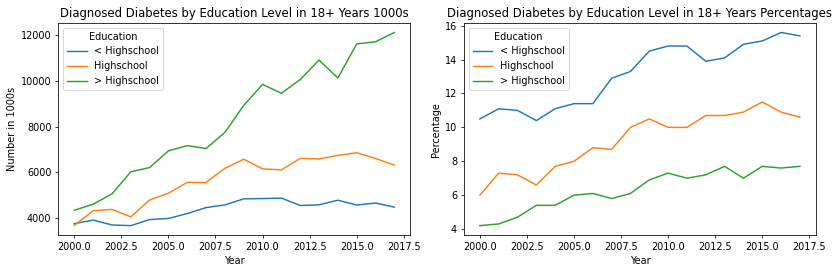

In [41]:
fig, axes = plt.subplots(nrows=1,ncols=2,dpi=70, figsize=(12,4))

plot00 = sns.lineplot(data=education_cleaner_df, x="yearid",y="Estimate",
                     hue="Education",ax=axes[0])
axes[0].set_title("Diagnosed Diabetes by Education Level in 18+ Years 1000s")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number in 1000s")
plt.tight_layout()

plot01 = sns.lineplot(data=education_percentage_df, x="yearid",y="Estimate",
                     hue="Education",ax=axes[1])
axes[1].set_title("Diagnosed Diabetes by Education Level in 18+ Years Percentages")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Percentage")
plt.tight_layout()

plt.show()

# Pie Plotting

## For 1000

In [53]:
education_pie = education_cleaner_df.groupby(["yearid","Education"])
sum_it_up = education_pie.sum()
sum_it_up

indicatorid  ageid  estimateid  datasetid  educationid  \
yearid Education                                                              
2000   < Highschool            1     99         101         40            1   
       Highschool              1     99         101         40            2   
       > Highschool            1     99         101         40            3   
2001   < Highschool            1     99         101         40            1   
       Highschool              1     99         101         40            2   
       > Highschool            1     99         101         40            3   
2002   < Highschool            1     99         101         40            1   
       Highschool              1     99         101         40            2   
       > Highschool            1     99         101         40            3   
2003   < Highschool            1     99         101         40            1   
       Highschool              1     99         101         40            2   
       > Highschool            1     99         101         40            3   
2004   < Highschool            1     99         101         40            1   
       Highschool              1     99         101         40            2   
       > Highschool            1     99         101         40            3   
2005   < Highschool            1     99         101         40            1   
       Highschool              1     99         101         40            2   
       > Highschool            1     99         101         40            3   
2006   < Highschool            1     99         101         40            1   
       Highschool              1     99         101         40            2   
       > Highschool            1     99         101         40            3   
2007   < Highschool            1     99         101         40            1   
       Highschool              1     99         101         40            2   
       > Highschool            1     99         101         40            3   
2008   < Highschool            1     99         101         40            1   
       Highschool              1     99         101         40            2   
       > Highschool            1     99         101         40            3   
2009   < Highschool            1     99         101         40            1   
       Highschool              1     99         101         40            2   
       > Highschool            1     99         101         40            3   
2010   < Highschool            1     99         101         40            1   
       Highschool              1     99         101         40            2   
       > Highschool            1     99         101         40            3   
2011   < Highschool            1     99         101         40            1   
       Highschool              1     99         101         40            2   
       > Highschool            1     99         101         40            3   
2012   < Highschool            1     99         101         40            1   
       Highschool              1     99         101         40            2   
       > Highschool            1     99         101         40            3   
2013   < Highschool            1     99         101         40            1   
       Highschool              1     99         101         40            2   
       > Highschool            1     99         101         40            3   
2014   < Highschool            1     99         101         40            1   
       Highschool              1     99         101         40            2   
       > Highschool            1     99         101         40            3   
2015   < Highschool            1     99         101         40            1   
       Highschool              1     99         101         40            2   
       > Highschool            1     99         101         40            3   
2016   < Highschool            1     99         101         40         

## For Year 2000

In [55]:
year_id = 2000
just_one_year = sum_it_up.loc[year_id]

In [57]:
just_one_year_grade = just_one_year["Estimate"]

In [58]:
just_one_year_grade

Education
< Highschool    3765
Highschool      3688
> Highschool    4349
Name: Estimate, dtype: int64

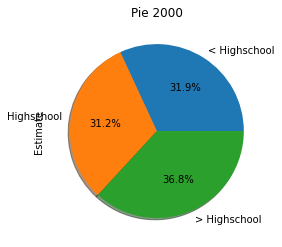

In [68]:
first_year_pie = just_one_year_grade.plot(kind="pie",y="Education", title="Pie 2000",autopct="%1.1f%%", shadow=True)

## For Year 2017

In [61]:
year_id_recent = 2017
just_one_year_recent = sum_it_up.loc[year_id_recent]

In [62]:
just_one_year_grade_recent = just_one_year_recent["Estimate"]

In [71]:
just_one_year_grade_recent

Education
< Highschool     4485
Highschool       6317
> Highschool    12105
Name: Estimate, dtype: int64

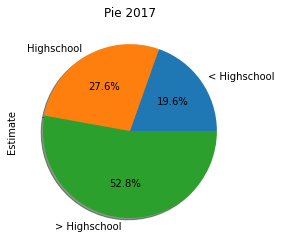

In [66]:
recent_year_pie = just_one_year_grade_recent.plot(kind="pie",y="Education",title="Pie 2017",autopct="%1.1f%%", shadow=True)